In [12]:
import numpy as np
import pickle
import pandas as pd
from scipy import stats
import scipy.ndimage
import matplotlib.pyplot as plt
%matplotlib inline
import networkx as nx
import matplotlib.collections as mcoll
import matplotlib.path as mpath
import community
import difflib
from PIL import Image
from sklearn.cluster import AgglomerativeClustering
from sklearn.ensemble import RandomForestClassifier
import os
from scipy.spatial.distance import cdist, pdist
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
import itertools
import sys
sys.path.append("/Users/rohanramesh/Documents/GitHub/Basketball_predictions/lib/")
import team_analysis as ta
import get_player_team_data as ptd

# Team analysis

For every year I will look at the structure or architecture of each team. Each node will be a player on a team, the edges between each node will be the max{ASTa * PTSb, ASTb * PTSa}. Based on the team architecture we will calculate a variety of graph theory metrics and see if there are patterns in those teams that are succesful. We will build a variety of team graph theory metrics and single player theory metrics to evaluate team and player performance.

In [2]:
# load in data
with open('/Users/rohanramesh/Documents/SportsData/NBA/AllYearlyData_2008_2018.pickle', 'rb') as handle:
    df_players = pickle.load(handle)

with open('/Users/rohanramesh/Documents/SportsData/NBA/YearlyTeamData.pickle', 'rb') as handle:
    df_teams = pickle.load(handle)
    
years_to_use = range(2008,2019)

Have to deal with formatting differences for the different websites

In [3]:
# have to redefined team names in team df to match the players version
for curr_year in years_to_use[1:]:
    # need to adjust for difference betwen Tm labels
    # these are all teams according to the player data
    list_of_teams_mult = df_players[str(curr_year)]['Tm']
    all_teams = list_of_teams_mult.drop_duplicates().tolist()

    # teams according to team df
    teams_according_to_team_df = df_teams[str(curr_year)]['Tm'].tolist()
    # remove everything after city name but before team acronym
    new_team_ = [curr_team[curr_team.rfind(" ")+1:] for curr_team in teams_according_to_team_df]
    # bc of team transferring from New Jersey to Brooklyn and websited not being up to date add
    if curr_year == 2012:
        new_team_ = [w.replace('BKN', 'NJN') for w in new_team_]
    
    # now iterate through new team and find best match from all_teams
    new_team_aligned = []
    for curr_team in new_team_:    
        new_team_aligned.append(difflib.get_close_matches(curr_team,all_teams, n=1)[0])

    df_teams[str(curr_year)]['Tm'] = new_team_aligned


In [4]:
# iterate through all years and all teams and build all relevant graphs
all_team_graphs = {}
# iterate through year 
for curr_year in years_to_use[1:]:
    list_of_teams_mult = df_players[str(curr_year)]['Tm']
    all_teams = list_of_teams_mult.drop_duplicates().tolist()
    all_team_graphs[str(curr_year)] = {}
    # iterate through all teams on that year and build graphs
    for curr_team in all_teams:
        all_team_graphs[str(curr_year)][curr_team] = ta.build_graphs_each_team(
            df_players,str(curr_year),curr_team)
        
    

Here are example graphs of a variety of different teams. Note that many of these teams seem to be dominated by single players that are on the edge of the graph and a distance from their teammates, with thick lines emanating from them denoting they generate high scoring potential

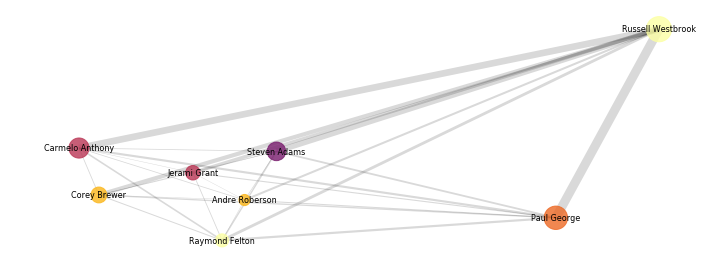

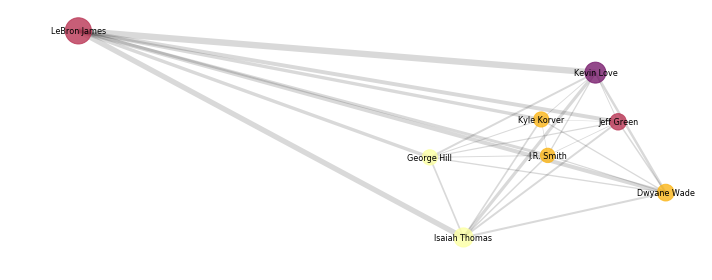

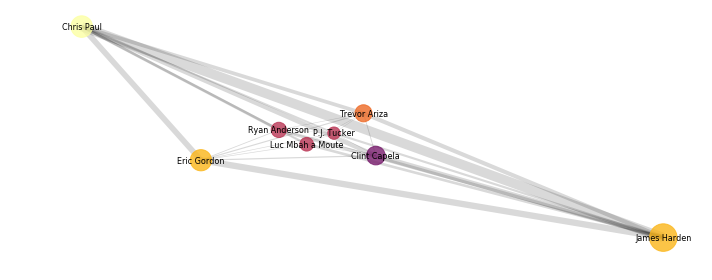

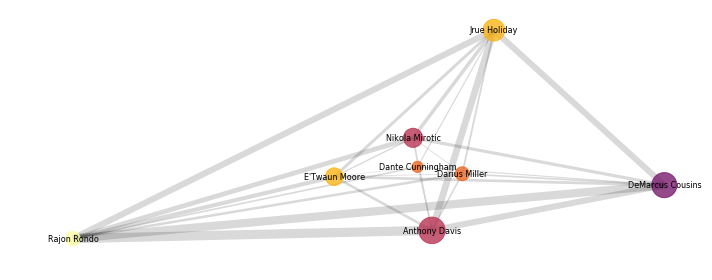

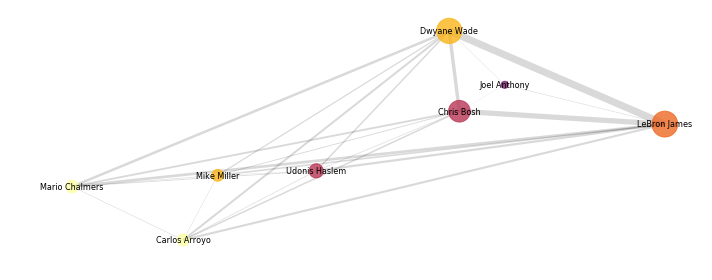

In [5]:
# To observe how the graph looks for a select set of teams I am familiar with
ta.visualize_graph_for_team_year(all_team_graphs['2018']['OKC'])
ta.visualize_graph_for_team_year(all_team_graphs['2018']['CLE'])
ta.visualize_graph_for_team_year(all_team_graphs['2018']['HOU'])
ta.visualize_graph_for_team_year(all_team_graphs['2018']['NOP'])
ta.visualize_graph_for_team_year(all_team_graphs['2011']['MIA'])
# save_path_tmp = "/Users/rohanramesh/Documents/SportsData/NBA/Figures/TeamGraphs/CLE_2018_full.png"
# visualize_graph_for_team_year(all_team_graphs['2018']['CLE'].to_undirected(),save_tag=True,
#                              save_path = save_path_tmp)

Now will calculate many of the graph theory metrics in the next few cells. Note many of these metrics will exist at the level of single players and how they fit into the team architecture. I will save both the single player metrics as well as combine all players from the team into a team metric that way I can evaluate single players and the team.

In [6]:
# weighted clustering - weighted tendency of nodes to connect to other nodes
# iterate through all years and then for each team calculate the weighted clustering metric
# each player will have their own associated value - to create a joint value for the team just take the mean
# also start to save and set aside the weighted clustering values for individual players so that can later add
# these values to the player dataFrame
weight_clust = {}
weighted_clustering_idx = {}
new_player_data = {}
# iterate through years
for curr_year in years_to_use[1:]:
    weight_clust[str(curr_year)] = {}
    all_teams = df_teams[str(curr_year)]['Tm'].drop_duplicates().tolist()
    weighted_clustering_idx[str(curr_year)] = []
    new_player_data[str(curr_year)] = {}
    new_player_data[str(curr_year)]['weighted_clustering'] = {}
    # iterate through all teams
    for curr_team in all_teams:
        G = all_team_graphs[str(curr_year)][curr_team].to_undirected()
        [A, player_data] = ta.get_graph_metric(G, metric="weighted_clustering", extra_weighting_values="None")
        weight_clust[str(curr_year)][curr_team] = A
        # build a ratio of the top weighted value over the sum of the rest
        weighted_clustering_idx[str(curr_year)].append(np.mean(A))
        # for single player data
        new_player_data[str(curr_year)]['weighted_clustering'].update(player_data)
    df_teams[str(curr_year)]['wclust_idx'] = weighted_clustering_idx[str(curr_year)]  

In [7]:
# to visualize how weighted clustering correlates with other team metrics
for curr_year in years_to_use[1:]:
    ta.plot_team_scatter(df_teams[str(curr_year)],'W','wclust_idx',str(curr_year))


In [8]:
# eigenvector, katz centrality, flow closeness - importance of single node
# calculate all of our measures of centrality from each individual graph for all years and all teams
# to calculate these centrality metrics for a team is a bit more tricky - here I have taken a few different approaches
# for eigenvector and katz centrality for the team - take the highest value for the entire team
# for current flow closeness centrality - these numbers tend to explode so will normalize the max value across
# the entire team by the summed values of all team members
eigcent_idx = {}
katzcent_idx = {}
flow_closeness = {}
# iterate over all years
for curr_year in years_to_use[1:]:
    all_teams = df_teams[str(curr_year)]['Tm'].drop_duplicates().tolist()
    eigcent_idx[str(curr_year)] = []
    katzcent_idx[str(curr_year)] = []
    flow_closeness[str(curr_year)] = []
    # initialize single player data
    new_player_data[str(curr_year)]['eigenvector_centrality'] = {}
    new_player_data[str(curr_year)]['katz_centrality'] = {}
    new_player_data[str(curr_year)]['current_flow_closeness_centrality'] = {}
    # iterate over all teams
    for curr_team in all_teams:
        # convert to undirected for this metric and get all centrality values
        G = all_team_graphs[str(curr_year)][curr_team].to_undirected()
        [A, player_data_ec] = ta.get_graph_metric(G, metric="eigenvector_centrality", extra_weighting_values="None")
        [B, player_data_kc] = ta.get_graph_metric(all_team_graphs[str(curr_year)][curr_team],
                             metric="katz_centrality", extra_weighting_values="None")
        [C, player_data_fc] = ta.get_graph_metric(G, metric="current_flow_closeness_centrality", extra_weighting_values="None") 
        # build a ratio of the top weighted value over the sum of the rest or take the max
        A.sort(reverse=True)
        eigcent_idx[str(curr_year)].append(A[0])
        katzcent_idx[str(curr_year)].append(np.max(B))
        flow_closeness[str(curr_year)].append(np.max(C)/np.sum(C))
        # for single player data
        new_player_data[str(curr_year)]['eigenvector_centrality'].update(player_data_ec)
        new_player_data[str(curr_year)]['katz_centrality'].update(player_data_kc)
        new_player_data[str(curr_year)]['current_flow_closeness_centrality'].update(player_data_fc)
    # update dataFrame
    df_teams[str(curr_year)]['eigcent'] = eigcent_idx[str(curr_year)]  
    df_teams[str(curr_year)]['katzcent'] = katzcent_idx[str(curr_year)]  
    df_teams[str(curr_year)]['flow_closeness'] = flow_closeness[str(curr_year)] 

In [9]:
# calculating the pagerank, closeness vitality, shortest path length, and the dijkstra length for 
# all years and all teams
# to calculate these metrics for a team is a bit more tricky - here I have taken a few different approaches:
# pagerank exists for each player and for the team I will take the pagerank for the player with the most assists
# dijkstra length exists for each player and for the team I will take the sum of all players
# shortest path length exclusively exists for the team
# closeness vitality exists for each player and I will take the maximim value for the team
pgrank = {}
splength = {}
dijlength = {}
vitality = {}
for curr_year in years_to_use[1:]:
    all_teams = df_teams[str(curr_year)]['Tm'].drop_duplicates().tolist()
    pgrank[str(curr_year)] = []
    splength[str(curr_year)] = []
    dijlength[str(curr_year)] = []
    vitality[str(curr_year)] = []
    # initialize single player data
    new_player_data[str(curr_year)]['pagerank'] = {}
    new_player_data[str(curr_year)]['closeness_vitality'] = {}
    new_player_data[str(curr_year)]['dijkstra_length'] = {}
    for curr_team in all_teams:
        G = all_team_graphs[str(curr_year)][curr_team]
        [A, player_data_pr] = ta.get_graph_metric(G, metric="pagerank")
        # lets take the pagerank of the best assist persion
        sorted_ast = sorted(nx.get_node_attributes(G,'ast').items(), key=lambda x: x[1])
        # this is the node index of the highest assist person so can save this value from A
        node_idx = list(G.nodes).index(sorted_ast[-1][0])
        pgrank[str(curr_year)].append(A[node_idx])
        # for length stuff
        B = dict(nx.all_pairs_dijkstra_path_length(G, weight='weight'))
        C = [B[i][j] for i in B for j in B[i]]
        # single player for dijkstra length - sum all lengths
        single_player_dijkstra = {}
        for i in B:
            tmp_vec = []
            for j in B[i]:
                tmp_vec.append(B[i][j])
            single_player_dijkstra[i] = np.sum(tmp_vec)
        dijlength[str(curr_year)].append(np.mean(C))
        D = nx.average_shortest_path_length(G, weight='weight')
        splength[str(curr_year)].append(D)
        # for vitality taking max
        [E, player_data_cv] = ta.get_graph_metric(all_team_graphs[str(curr_year)][curr_team].to_undirected(),
                             metric="closeness_vitality")
        E.sort(reverse=True)
        vitality[str(curr_year)].append(np.max(E))
        # for single player data
        new_player_data[str(curr_year)]['pagerank'].update(player_data_pr)
        new_player_data[str(curr_year)]['dijkstra_length'].update(single_player_dijkstra)
        new_player_data[str(curr_year)]['closeness_vitality'].update(player_data_cv)
    df_teams[str(curr_year)]['pgrank'] = pgrank[str(curr_year)]  
    df_teams[str(curr_year)]['splength'] = splength[str(curr_year)] 
    df_teams[str(curr_year)]['dijlength'] = dijlength[str(curr_year)] 
    df_teams[str(curr_year)]['vitality'] = vitality[str(curr_year)]

In [10]:
# lets put the single player stats from the graph approach into each year for each player
# iterate through each year
for curr_year in years_to_use[1:]:
    # iterate through each method calculated
    for curr_graph_metric in list(new_player_data[str(curr_year)]):
        # list of players from that year single player metrics
        curr_players = df_players[str(curr_year)]['Player'].tolist()
        dict_to_add = {}
        dict_to_add[curr_graph_metric] = []
        for i in curr_players:
            if i in new_player_data[str(curr_year)][curr_graph_metric]:
                dict_to_add[curr_graph_metric].append(new_player_data[str(curr_year)][curr_graph_metric][i])
            else:
                dict_to_add[curr_graph_metric].append(np.nan)
        df_players[str(curr_year)][curr_graph_metric] = dict_to_add[curr_graph_metric]

In [1740]:
# to save newly combined single player df if want to
with open('/Users/rohanramesh/Documents/SportsData/NBA/SinglePlayerDatawGraphMetrics.pickle', 'wb') as handle:
    pickle.dump(df_players, handle, protocol=pickle.HIGHEST_PROTOCOL)

Try and predict advanced stats like PER (amalgamation of single player stats with a higher value corresponding to a better player, and an average player having a value of 15) from the graph theory metrics for single players.

['weighted_clustering', 'eigenvector_centrality', 'katz_centrality', 'current_flow_closeness_centrality', 'pagerank', 'closeness_vitality', 'dijkstra_length']
[13.3 16.5]
Out-of-bag score estimate: 0.579
Mean accuracy score: 0.575
0.5786458333333333
[0.12887921 0.24210716 0.05867792 0.13902445 0.16702453 0.14661411
 0.11767263]


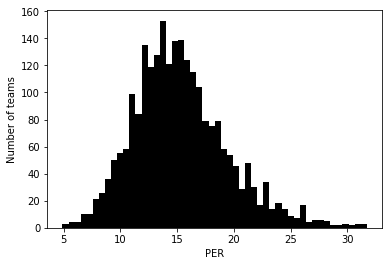

Normalized confusion matrix


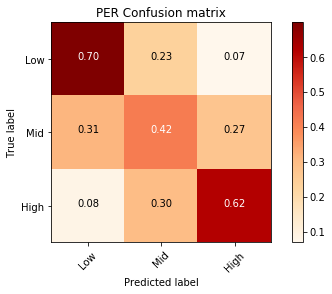

In [11]:
# Lets build a random forests classifier to try and predict PER from graph theory metrics for individual players
# To get our n we will group across all years
# Initially will test with a different number of trees (don't thing this will be a big deal)
# I will also use a set aside test data set and contrast this with the out of bag score (values held out during tree
# construction) to make sure not overfitting
metrics_to_predict = ['PER']
# here are the metrics from the graphs to include
graph_metrics = ['weighted_clustering', 'eigenvector_centrality', 'katz_centrality', 
                 'current_flow_closeness_centrality', 'pagerank', 'closeness_vitality', 
                 'dijkstra_length']
print(graph_metrics)
# lets divide these distributions into thirds
quartiles_for_stats = {}
for curr_stat in metrics_to_predict:
    # this is the curr stat values for all years
    curr_stat_values = []
    for curr_year in years_to_use[1:]:
        year_stat = df_players[str(curr_year)][curr_stat].tolist()
        curr_stat_values.extend(year_stat)
    curr_stat_values = np.asarray(curr_stat_values)
    # graph metrics for all years
    curr_graph_metrics = []
    for curr_year in years_to_use[1:]:
        year_stat = df_players[str(curr_year)][graph_metrics].as_matrix()
        curr_graph_metrics.extend(year_stat)
    curr_graph_metrics = np.asarray(curr_graph_metrics) 
    # make sure don't include any nans for classification purposes
    idx_nan = np.isnan(curr_graph_metrics[:,1])
    idx_nonnan = [i for i, x in enumerate(idx_nan) if ~x]
    curr_graph_metrics = curr_graph_metrics[idx_nonnan,:]
    curr_stat_values = curr_stat_values[idx_nonnan]
    # divide up the data into some fraction - calling them quartiles but actually using thirds
    mid_quartiles = np.percentile(curr_stat_values, q=[100*(1/3), 100*(2/3)])
    print(mid_quartiles)
    # build a vector that will allow for fast indexing into the stats in each quartile
    team_quartile_vec = np.zeros(np.shape(curr_stat_values))
    for i in range(0,len(curr_stat_values)):
        for j in range(0,len(mid_quartiles)+1):
            if j == 0:
                if curr_stat_values[i] < mid_quartiles[0]:
                    team_quartile_vec[i] = 0 
            elif j == len(mid_quartiles):
                if (curr_stat_values[i] >= mid_quartiles[-1]) :
                    team_quartile_vec[i] = j
            else:
                if (curr_stat_values[i] >= mid_quartiles[j-1]) & (curr_stat_values[i] < mid_quartiles[j]):
                    team_quartile_vec[i] = j                   
    # now will train on 80% and test on 20%
    X_train, X_test, y_train, y_test = train_test_split(curr_graph_metrics, 
                        team_quartile_vec, test_size=0.2)
    oob_score_rf = []
    test_pred_accuracy = []
#     for curr_tree_n in range(20,510,10): # if was iterating over different tree numbers uncomment
    rf = RandomForestClassifier(n_estimators=100,oob_score=True)
    rf.fit(X_train, y_train)
    A = rf.oob_decision_function_
    predicted = rf.predict(X_test)
    # want to compare and contrast accuracy from test set vs the out of bag score- should be same
    accuracy = accuracy_score(y_test, predicted)
    oob_score_rf.append(rf.oob_score_)
    test_pred_accuracy.append(accuracy)
    print(f'Out-of-bag score estimate: {rf.oob_score_:.3}')
    print(f'Mean accuracy score: {accuracy:.3}')
    print(rf.oob_score_)
    print(rf.feature_importances_)
    plt.hist(curr_stat_values, bins= 50, color = 'black')
    plt.xlabel(curr_stat)
    plt.ylabel('Number of teams')
    # if saving
#     plt.savefig(
#         "/Users/rohanramesh/Documents/SportsData/NBA/Figures/RF_Classification/%s_histogram" % curr_stat , 
#         bbox_inches='tight', dpi = 100)
    plt.show()
    confmat = confusion_matrix(y_test,predicted)
    classes = ['Low', 'Mid', 'High']
    ta.plot_confusion_matrix(confmat, classes, normalize=True,
                          title='%s Confusion matrix' % curr_stat,cmap=plt.cm.OrRd, save_tag = True)

When I was trying to decide how many trees to use in my forest, I iterated over different tree numbers and the cell for plotting these results are shown below. This will be non-functional if you are not iterating over many different tree numbers.

In [21]:
# This cell will only work if you have iterated over different tree numbers to make sure this isn't a deciding 
# factor in classification accuracy (will plot test set accuracy and oob accuracy)
# Print the prediction across different numbers of trees
fig, ax = plt.subplots()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.plot(range(20,510,10),oob_score_rf, '-', color= 'black', linewidth = 2)
plt.plot(range(20,510,10),test_pred_accuracy, '--', color = 'black', linewidth = 2)
xlim_curr = plt.xlim()
plt.plot([xlim_curr[0], xlim_curr[1]], [33, 33], color='gray', linestyle=':', linewidth=1)
plt.ylim(0,100)
plt.xlim(0,500)
plt.xlabel('Number of trees in forest')
plt.ylabel('Percent correct')
plt.legend(['Out of bag','Test set'])
# plt.savefig(
#     "/Users/rohanramesh/Documents/SportsData/NBA/Figures/RF_Classification/nTrees_classification", 
#     bbox_inches='tight', dpi = 100)
plt.show()

Make more formal figures for the RF classifier performance. Make a histogram showing single player PER and the groups I tried to predict as well as the relative importance of all graph theory metrics

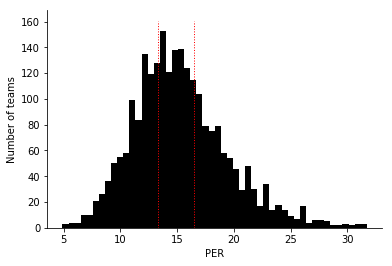

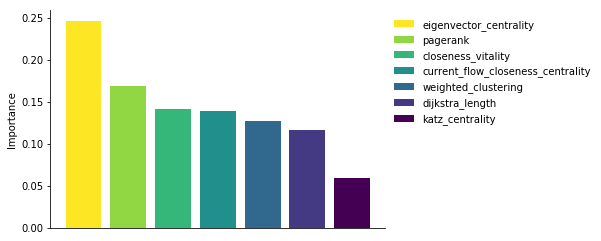

In [22]:
# Make figures for RF classifier
# plot histogram again with red lines to mark quantiles
fig, ax = plt.subplots()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.hist(curr_stat_values, bins= 50, color = 'black')
ylim_curr = plt.ylim()
plt.plot([mid_quartiles[0], mid_quartiles[0]], [ylim_curr[0], ylim_curr[1]], color='red', linestyle=':', linewidth=1)
plt.plot([mid_quartiles[1], mid_quartiles[1]], [ylim_curr[0], ylim_curr[1]], color='red', linestyle=':', linewidth=1)
plt.xlabel(curr_stat)
plt.ylabel('Number of teams')
# plt.savefig(
#     "/Users/rohanramesh/Documents/SportsData/NBA/Figures/RF_Classification/%s_histogram" % curr_stat , 
#     bbox_inches='tight', dpi = 100)
plt.show()
# plot RF importance
rf_importance = rf.feature_importances_
sorted_idx = np.argsort(rf_importance*-1)
fig, ax = plt.subplots()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
xlist = [graph_metrics[i] for i in sorted_idx]
bar_cmap = plt.get_cmap('viridis_r',len(sorted_idx))
rects1 = ax.bar(range(0,len(sorted_idx)), rf_importance[sorted_idx], 
                color = bar_cmap.colors)
ax.get_xaxis().set_ticks([])
plt.ylabel('Importance')
plt.legend(rects1, xlist, frameon = False, loc=0, bbox_to_anchor=(1, 1))
# plt.savefig(
#     "/Users/rohanramesh/Documents/SportsData/NBA/Figures/RF_Classification/%s_category_importance" % curr_stat , 
#     bbox_inches='tight', dpi = 100)
plt.show()

Lets do clustering on the graph theory metrics to evaluate how teams are constructed and if their is a pattern between how teams are constructed and their win / loss success. Using tsne for dimensionality reduction eventually

In [27]:
# Perform tsne on the graph theory metrics that exist for each team
# Want to know if there is something about team organization that is consistent across multiple teams
# clustering of team types - metrics to use
graph_metrics = ['wclust_idx','eigcent','flow_closeness','pgrank','dijlength','splength','vitality']
curr_graph_metrics = []
team_and_year = []
# iterating over all years so that can see if this changes across years
for curr_year in years_to_use[1:]:
    year_stat = df_teams[str(curr_year)][graph_metrics].as_matrix()
    curr_graph_metrics.extend(year_stat)
    # build variable that will save the teams and the year for later indexing
    # ['Team name' year]
    curr_teams = df_teams[str(curr_year)][['Tm']].as_matrix()
    team_plus_year = [[i[0], curr_year] for i in curr_teams]
    team_and_year.extend(team_plus_year)
curr_graph_metrics = np.asmatrix(curr_graph_metrics)
# lets normalize each column by the mean and the std
for curr_col in range(0,np.shape(curr_graph_metrics)[1]):
    curr_graph_metrics[:,curr_col] = ta.normalize(curr_graph_metrics[:,curr_col])

# to make sure normalized correctly
# plt.plot(curr_graph_metrics)
# plt.legend(graph_metrics)
# plt.show()
# Run tsne
tsne = TSNE(n_components=2, verbose=1, perplexity=15, n_iter=1000)
tsne_results = tsne.fit_transform(curr_graph_metrics)

[t-SNE] Computing 46 nearest neighbors...
[t-SNE] Indexed 300 samples in 0.000s...
[t-SNE] Computed neighbors for 300 samples in 0.007s...
[t-SNE] Computed conditional probabilities for sample 300 / 300
[t-SNE] Mean sigma: 0.007720
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.354431
[t-SNE] Error after 1000 iterations: 0.611285


I want to cluster teams based on graph theory metrics so first have to figure out how many clusters to use. I will use Agglomerative Hierarchical Clustering, but will validate the number of clusters using multiple approaches.

In [31]:
# Plot all teams with the color corresponding to the cluster number so that I can 
# get an idea for how many clusters there are
# Also plot the mean number of groups in each cluster
all_cnumber = []
for clusters_use in range(1,16):
    model = AgglomerativeClustering(linkage='ward',
                                                n_clusters=clusters_use)
    model.fit(curr_graph_metrics)

    tmp_labels = model.labels_
    cm = plt.get_cmap('plasma_r',clusters_use)
    cmap_colors = [cm.colors[i] for i in tmp_labels]
    plt.scatter(tsne_results[:,0],tsne_results[:,1],c=cmap_colors)
    plt.xlabel('tSNE-1')
    plt.ylabel('tSNE-2')
#     plt.savefig(
#         "/Users/rohanramesh/Documents/SportsData/NBA/Figures/ClusteringValidation/nClustersAggHier/%s_clusters" % str(clusters_use), 
#         bbox_inches='tight', dpi = 100)
    plt.show()
#   lets look at the mean number of groups per label
    ngroups_per_split = []
    for i in range(0,clusters_use):
        ngroups_per_split.append(len(np.where(tmp_labels == i)[0]))
    all_cnumber.append(np.mean(ngroups_per_split))
# plotting number of teams per cluster
plt.plot(range(1,16),all_cnumber,'-o')
plt.xlabel('Number of clusters')
plt.ylabel('Mean number of groups per cluster')
# plt.savefig(
#     "/Users/rohanramesh/Documents/SportsData/NBA/Figures/ClusteringValidation/nTeams_per_cluster", 
#     bbox_inches='tight', dpi = 100)
plt.show()

In [34]:
# Validate using 10 clusters by looking at variance explained via k-means
K = range(1,30)
KM = [KMeans(n_clusters=k).fit(curr_graph_metrics) for k in K]
centroids = [k.cluster_centers_ for k in KM]

D_k = [cdist(curr_graph_metrics, cent, 'euclidean') for cent in centroids]
cIdx = [np.argmin(D,axis=1) for D in D_k]
dist = [np.min(D,axis=1) for D in D_k]
avgWithinSS = [sum(d)/curr_graph_metrics.shape[0] for d in dist]

# Total with-in sum of square
wcss = [sum(d**2) for d in dist]
tss = sum(pdist(curr_graph_metrics)**2)/curr_graph_metrics.shape[0]
bss = tss-wcss


# elbow curve
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(K, avgWithinSS, '-o')
plt.xlabel('Number of clusters')
plt.ylabel('Average within-cluster sum of squares')
plt.title('Elbow for KMeans clustering')


fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(K, bss/tss*100, '-o')
plt.xlabel('Number of clusters')
plt.ylabel('Percentage of variance explained')
plt.title('Elbow for KMeans clustering')
# plt.savefig(
#     "/Users/rohanramesh/Documents/SportsData/NBA/Figures/ClusteringValidation/nTeams_per_cluster_kmeans", 
#     bbox_inches='tight', dpi = 100)
plt.show()

Based on these results will use 10 clusters for Agglomerative Hierarchical clustering

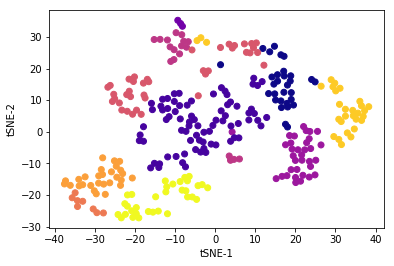

In [35]:
# Actually use 10 clusters and agglomerative hierarchical clustering to determine labels for all 300 teams
clusters_use = 10
model = AgglomerativeClustering(linkage='ward',
                                            n_clusters=clusters_use)
model.fit(curr_graph_metrics)
# these are the labels for each team in terms of cluster number
agg_clust_labels = model.labels_

# plot with each cluster being a different color
cm = plt.get_cmap('plasma_r',clusters_use)
cmap_colors = [cm.colors[i] for i in agg_clust_labels]
plt.scatter(tsne_results[:,0],tsne_results[:,1],c=cmap_colors)
plt.xlabel('tSNE-1')
plt.ylabel('tSNE-2')
# plt.savefig(
#     "/Users/rohanramesh/Documents/SportsData/NBA/Figures/tsne_%s.png" % 'Agg_Clusters', 
#     bbox_inches='tight', dpi = 100)
plt.show()


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


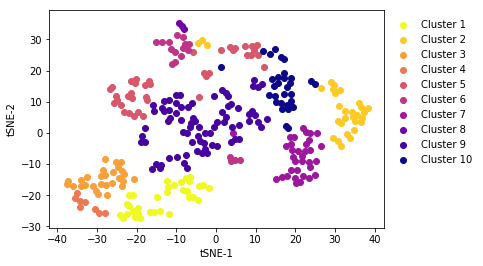

In [43]:
# for pretty saving purposes
# lets plot tsne by cluster
A = range(2009,2019)
print(list(set(agg_clust_labels)))
B = ["Cluster "+str(i+1) for i in range(0,len(list(set(agg_clust_labels))))]
cm = plt.get_cmap('plasma_r',10)
cmap_colors = [cm.colors[i] for i in range(0,len(list(set(agg_clust_labels))))]
for i in range(0,len(list(set(agg_clust_labels)))):
    idx = [f for f, x in enumerate(agg_clust_labels) if x == i]
    plt.scatter(tsne_results[idx,0],tsne_results[idx,1],c=cmap_colors[i])


    
plt.xlabel('tSNE-1')
plt.ylabel('tSNE-2')
plt.legend(B, frameon = False, loc=0, bbox_to_anchor=(1, 1))
# plt.savefig(
#     "/Users/rohanramesh/Documents/SportsData/NBA/Figures/tsne/tsne_%s.png" % 'Agg_Clusters', 
#     bbox_inches='tight', dpi = 100)
plt.show()

I want to be able to look at all teams in a given cluster so will plot all of the graph architecture for these teams in a folder with each cluster name. See Figures/TeamGraphs folder for figures for all teams.

In [1789]:
# Visualize all teams in each cluster and save
# for each cluster lets plot all of the graphs for teams in that cluster
for curr_cluster in range(0,10):
    idx_of_that_cluster = np.where(agg_clust_labels == curr_cluster)
    for i in idx_of_that_cluster[0]:
        curr_team_year = team_and_year[i]
#         print(curr_team_year)
#         visualize_graph_for_team_year(all_team_graphs[str(curr_team_year[1])][curr_team_year[0]],
#               save_tag=True, 
#               save_path = "/Users/rohanramesh/Documents/SportsData/NBA/Figures/TeamGraphs/Cluster%s/%s_%s"
#                                       % (curr_cluster,str(curr_team_year[1]),curr_team_year[0]))

In [39]:
# Make matrix of all metrics we care about for easy fast indexing
all_metrics_list = list(df_teams['2018'])
all_metrics_list = [list(df_teams['2018'])[j] for j 
           in range(0,len(list(df_teams['2018']))) if ptd.isfloat(df_teams['2018'].iloc[0,j])]
# print(all_metrics_list)
all_metrics = []
for curr_year in years_to_use[1:]:
    year_stat = df_teams[str(curr_year)][all_metrics_list].as_matrix()
    all_metrics.extend(year_stat)
all_metrics = np.asmatrix(all_metrics)



For visualization purposes, lets plot any metric we want overlayed on the clusters so we can see if there is a pattern in certain clusters being better at for example points per game or assists.

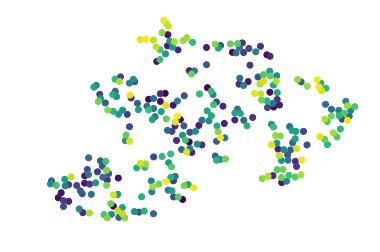

In [41]:
# For any stat overlay the tsne plot with colors - dark = low stat and light = high stat
stat_plot = 'W'
rm = plt.get_cmap('viridis',np.shape(all_metrics)[0])
vec_use = all_metrics[:,all_metrics_list.index(stat_plot)]
# vec_use = all_metrics[:,all_metrics_list.index('W')] - all_metrics[:,all_metrics_list.index('L')]
ta.plot_tsne_with_colors_sorted(tsne_results,vec_use, 
                             rm.colors, save_tag=False, save_name=stat_plot)

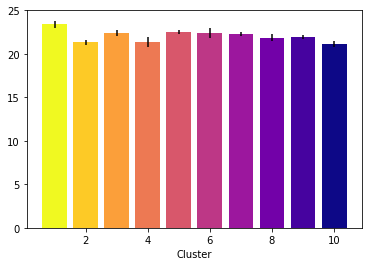

In [42]:
# Different version of same plot - but plot as bar plot for any stat by cluster
curr_stat = 'APG'
vector = all_metrics[:,all_metrics_list.index(curr_stat)]
save_path_use = "/Users/rohanramesh/Documents/SportsData/NBA/Figures/BarPlots/bar_clusters_%s" % (curr_stat)
ta.barplot_tsne_clust(agg_clust_labels, vector,save_tag=False,save_path=save_path_use,plot_n_in_cluster=False)

As a control, want to make sure that the clusters are not just the architecture of teams change over time. Let's plot so that each color corresponds to a year.

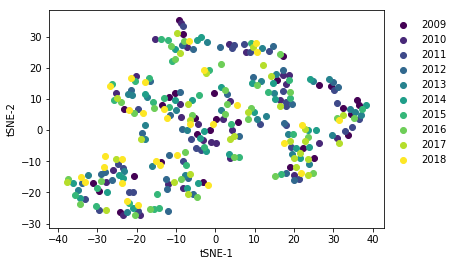

In [44]:
# Make sure there isn't a relationship between clusters and year so overlay the year on tsne plot
# lets plot tsne by year
year_vec = [i[1] for i in team_and_year]
A = range(2009,2019)
B = [str(i) for i in A]
cm = plt.get_cmap('viridis',len(A))
cmap_colors = [cm.colors[i] for i in range(0,len(A))]
for i in range(0,len(A)):
    idx = [f for f, x in enumerate(year_vec) if x == A[i]]
    plt.scatter(tsne_results[idx,0],tsne_results[idx,1],c=cmap_colors[i])


    
plt.xlabel('tSNE-1')
plt.ylabel('tSNE-2')
plt.legend(B, frameon = False, loc=0, bbox_to_anchor=(1, 1))
# plt.savefig(
#     "/Users/rohanramesh/Documents/SportsData/NBA/Figures/tsne_%s.png" % 'Agg_Clusters_by_year', 
#     bbox_inches='tight', dpi = 100)
plt.show()

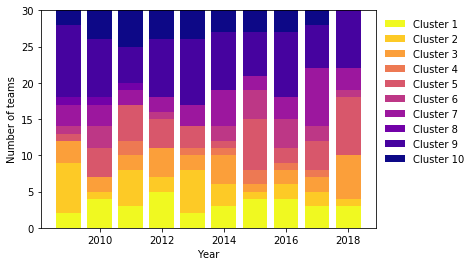

In [45]:
# also make a stacked bar plot for each year for the number of clusters
# curr_year = 2018
all_years_cluster_n = {}
curr_sum = list(np.zeros(np.shape(list(set(agg_clust_labels)))))
bar_cmap = plt.get_cmap('plasma_r',np.max(agg_clust_labels)+1)
for j in list(set(agg_clust_labels)):
    all_years_cluster_n[str(j)] = []
    # iterate through each year and get number of teams per cluster
    for curr_year in range(2009,2019):
        idx_year = [f for f, x in enumerate(year_vec) if x == curr_year]
        curr_labels = agg_clust_labels[idx_year]
        idx_group = [f for f, x in enumerate(curr_labels) if x == j]
        all_years_cluster_n[str(j)].append(len(idx_group))
    # now lets make plot
    plt.bar(range(2009,2019),all_years_cluster_n[str(j)],
           bottom=curr_sum, color = bar_cmap.colors[j])
    # add lists
    curr_sum = [sum(x) for x in zip(curr_sum, all_years_cluster_n[str(j)])]
plt.xlabel('Year')
plt.ylabel('Number of teams')
cluster_legend = ["Cluster " + str(i+1) for i in list(set(agg_clust_labels))]
plt.legend(cluster_legend, frameon = False, loc=0, bbox_to_anchor=(1, 1))
# plt.savefig(
#     "/Users/rohanramesh/Documents/SportsData/NBA/Figures/BarPlots/nClusters_each_year.png", 
#     bbox_inches='tight', dpi = 100)
plt.show()

In [2072]:
# look at df for a single team and write a CSV
stats_visualize = ['Player', 'Pos', 'Tm', 'PS/G', 'AST', 'MP', 'FG', 'FGA', '2P%', '3P%']
idx = df_players['2018']['Tm'] == 'GSW'
A = df_players['2018'][stats_visualize][idx].sort_values(['MP'], ascending=False)
file_name = "/Users/rohanramesh/Documents/SportsData/NBA/Tables/GSW_2018"
A.to_csv(file_name, sep='\t')

We do, however, know that the way basketball is played has shifted in recent years, with a dramatic increase in 3-point shooting and "small-ball" lineups with more similar-sized players on the floor at the same time. Lets actually confirm this and plot how 3-point shooting has changed over years:

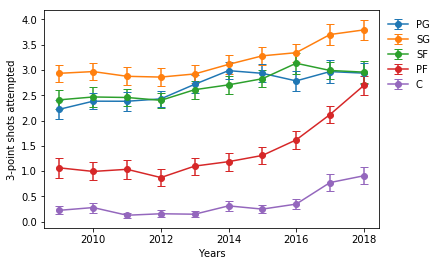

In [46]:
# plot any metric across years by position
# goal: to visualize the movement to small bar and more 3-point shooting
stats_plot_across_years = ['3PA']
for curr_stat in stats_plot_across_years:
    # positions to consider
    pos_list = ['PG', 'SG', 'SF', 'PF', 'C']
    for curr_pos in pos_list:
        curr_mean = []
        curr_sem = []
        for curr_year in years_to_use[1:]:
            # only going to include players that play at least 10 min per game
            idx = (df_players[str(curr_year)]['Pos'] == curr_pos) & (df_players[str(curr_year)]['MP'] > 10)
            curr_vec = df_players[str(curr_year)][curr_stat][idx]
            curr_mean.append(np.nanmean(curr_vec))
            curr_sem.append(stats.sem(curr_vec,nan_policy='omit'))
        plt.errorbar(years_to_use[1:],curr_mean,curr_sem,marker='o',capsize=4)
    plt.legend(pos_list,loc='best',frameon = False, bbox_to_anchor=(1, 1))
#     plt.ylabel(curr_stat)
    plt.ylabel('3-point shots attempted')
    plt.xlabel('Years')
#     plt.savefig(
#         "/Users/rohanramesh/Documents/SportsData/NBA/Figures/BarPlots/Yearly_plots_by_pos_%s.png" % curr_stat, 
#         bbox_inches='tight', dpi = 100)
    plt.show()

Let's look at those clusters that are either succesful (more wins than losses) and those that are less succesful (more losses than wins) to see if these teams are organized differently.

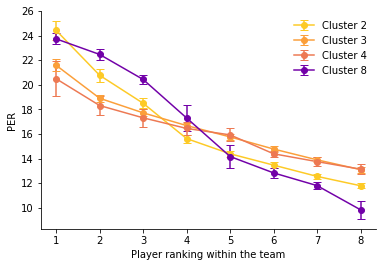

In [48]:
# Choose clusters to plot, choose stat to look at, and look at the top 8 players per team for that stat
# lets iterate over each cluster, get the teams from that cluster and sort by different metrics
unique_clusters = list(set(agg_clust_labels))
mean_stat = {}
agg_cmap = plt.get_cmap('plasma_r',np.max(agg_clust_labels)+1)
# this is the stat we are looking at
stat_look_at = 'PER'
# clusters to consider - will take all teams from this cluster
clusters_look_at = [1, 2, 3, 7]
new_cluster_legend = [cluster_legend[ii] for ii in clusters_look_at]
fig, ax = plt.subplots()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
for curr_cluster in clusters_look_at:
    idx_of_that_cluster = np.where(agg_clust_labels == curr_cluster)
    i = 1
    mean_stat[str(curr_cluster)] = []
    # get all teams in that cluster and players on that team
    for i in idx_of_that_cluster[0]:
        curr_year = team_and_year[i][1]
        curr_team = team_and_year[i][0]
        idx_team = (df_players[str(curr_year)]['Tm'] == curr_team) & (df_players[str(curr_year)]['MP'] > 10)
        curr_df = df_players[str(curr_year)][['Player', 
                            stat_look_at]][idx_team].sort_values(stat_look_at, ascending=False)
        # lets get PER of top 8 players
        A = curr_df[stat_look_at].iloc[0:8].as_matrix()
        mean_stat[str(curr_cluster)].append(A)
    curr_mean = np.mean(mean_stat[str(curr_cluster)],axis=0)
    curr_sem = stats.sem(mean_stat[str(curr_cluster)],axis=0,nan_policy='omit')
    # and plot
    plt.errorbar(range(1,9),curr_mean,curr_sem,marker='o',capsize=4,color=agg_cmap.colors[curr_cluster])
plt.legend(new_cluster_legend, loc='best',frameon = False, bbox_to_anchor=(1, 1))
plt.xlabel('Player ranking within the team')
plt.ylabel(stat_look_at)
# plt.savefig(
#     "/Users/rohanramesh/Documents/SportsData/NBA/Figures/TeamGraphs/TeamMetrics_per_player_%s.png" % stat_look_at, 
#     bbox_inches='tight', dpi = 100)
plt.show()

In [2372]:
# lets save multiple useful variables
# with open('/Users/rohanramesh/Documents/SportsData/NBA/YearlyPlayerStatsAll_TeamAll.pickle', 'wb') as handle:
#     pickle.dump([df_players, df_teams], handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('/Users/rohanramesh/Documents/SportsData/NBA/Clusters_tsne_rf.pickle', 'wb') as handle:
#     pickle.dump([agg_clust_labels, tsne_results, rf], handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('/Users/rohanramesh/Documents/SportsData/NBA/All_team_metrics_years.pickle', 'wb') as handle:
#     pickle.dump([all_metrics], handle, protocol=pickle.HIGHEST_PROTOCOL)

In [13]:
# For quick visualization purposes to look at correlation between two metrics
# Want to get a sense for how graph metrics correlate with individual player stats
# plot scatter of 2 stats against each other
single_player_stats = ['PER']
graph_stats = list(new_player_data[str(curr_year)])
for i in single_player_stats:
    for j in graph_stats:
        ta.plot_scatter_across_years(i,j,df_players)
